## simple plotting of daily Covid cases / hospital admissions / deaths in the UK, start of 2020 to present day

data source: https://coronavirus.data.gov.uk/details/about-data#daily-and-cumulative-numbers-of-cases

downloads: https://coronavirus.data.gov.uk/details/download
using query:
https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

f = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv'

CASES = 'newCasesByPublishDate'
ADM = 'newAdmissions'
DEATHS = 'newDeaths28DaysByDeathDate'

ADM_SHIFT = 14
DEATHS_SHIFT = 30
AVERAGE_LEN = 7

In [61]:
df = pd.read_csv(f, header=0, sep=',')
df['date']= df['date'].apply(pd.to_datetime)  ## date type coercion

# df.head()

## start end end dates for this analysis
counts = df['date'].count()
d1 = df.iloc[counts-1]['date']
d2 = df.iloc[0]['date']
print('time interval covered by the data: {d1} ---> {d2}'.format(d1=d1, d2=d2))

time interval covered by the data: 2020-01-31 00:00:00 ---> 2021-06-13 00:00:00


In [146]:
## utils

def filterByYearAndMonth(df, year=None, monthStart= None, monthEnd= None):
    
    if year == None:
        return df
    
    df1 =  df[pd.DatetimeIndex(df['date']).year == year]
    if monthStart is not None and monthEnd is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month >= monthStart]
        df1 = df1[pd.DatetimeIndex(df1['date']).month <= monthEnd]
    elif monthStart is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month == monthStart]
        
#     print(df1.head())
    return df1

def shiftColumnBy(column,s, df):
    df1 = df.copy()
    df1[column] = df[column].shift(s)   # shift "up" one column by s periods
    return df1
    
# remove  records containing nulls. this happens afer shifting: last s rows will have NaN in the shifted column
def removeNullRecords(df):
    df1 = df.copy()
    df1 = df1.dropna(subset = [ADM,DEATHS])
    return df1


def plotCasesVsAdmissions(df, average=True):
    
    if average:
        df['avgCASES'] = df[CASES].rolling(AVERAGE_LEN).mean()
        df['avgADM']   = df[ADM].rolling(AVERAGE_LEN).mean()

    # plot ADM against CASES
    fig, ax1 = plt.subplots()
    fig.set_figwidth(12)
    ax11 = ax1.twinx()
    
    if average:
        ax1.plot(df['date'], df['avgCASES'], label='new daily cases (left axis) - '+str(AVERAGE_LEN)+' days average')
        ax11.plot(df['date'], df['avgADM'], color="r", label='new daily admissions (right axis) - '+str(AVERAGE_LEN)+' days average')
    else:
        ax1.plot(df['date'], df[CASES], label='new daily cases (left axis)')
        ax11.plot(df['date'], df[ADM], color="r", label='new daily admissions (right axis)')
        
    ax1.legend(loc=0)
    ax11.legend(loc=0)
    ax1.set_title("daily new admissions against new cases (time shift "+str(ADM_SHIFT)+" days)")

    
def plotCasesVsDeaths(df, average=True):
    
    if average:
        df['avgCASES']  = df[CASES].rolling(7).mean()
        df['avgDEATHS'] = df[DEATHS].rolling(7).mean()

    # plot ADM against CASES and DEATHS against CASES
    fig, ax2 = plt.subplots()
    fig.set_figwidth(12)
    ax22 = ax2.twinx()
    
    if average:
        ax2.plot(df['date'], df['avgCASES'], label='new daily cases (left axis) - '+str(AVERAGE_LEN)+' days average')
        ax22.plot(df['date'], df['avgDEATHS'], color="r", label='new daily deaths (right axis) - '+str(AVERAGE_LEN)+' days average')
    else:        
        ax2.plot(df['date'], df[CASES], label='new daily cases (left axis)')
        ax22.plot(df['date'], df[DEATHS], color="c", label='new daily deaths reported by death date (right axis)')
                
    ax22.set_yscale('log')   
    ax22.legend()
    ax2.set_title("daily new deaths against new cases (time shift "+str(DEATHS_SHIFT)+" days) -- log scale")

    

def plotAdmToCasesRatios(df, average=True):

    ## simple ratios
    df1 = df.copy()
    df1['AdmissionsToCasesRatio'] = df1[ADM] / df1[CASES]

    if average:
        df1['avgRatio']  = df1['AdmissionsToCasesRatio'].rolling(AVERAGE_LEN).mean()

    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    if average:
        ax.plot(df1['date'], df1['avgRatio'], label = 'Admissions to cases Ratio - '+str(AVERAGE_LEN)+' days average')
        ax.set_title('Admissions to cases Ratio (time shift '+str(ADM_SHIFT)+' days) - '+str(AVERAGE_LEN)+' days average   -- autoscaled')
    else:
        ax.plot(df1['date'], df1['AdmissionsTocasesRatio'], color="r", label = 'Admissions to cases Ratio')
        ax.set_title('Admissions to cases Ratio (time shift '+str(ADM_SHIFT)+' days)  -- autoscaled')

    ## autoscale
    if average:
        m = max(df1.iloc[AVERAGE_LEN:]['avgRatio'])
    else:
        m = max(df1.iloc[AVERAGE_LEN:]['AdmissionsToCasesRatio']) 
    ax.set_ylim([0, m])  
    ax.legend()

    
def plotDeathsToCasesRatios(df, average=True):

    ## simple ratios
    df1 = df.copy()
    df1['DeathsToCasesRatio'] = df1[DEATHS] / df1[CASES]

    if average:
        df1['avgRatio']  = df1['DeathsToCasesRatio'].rolling(AVERAGE_LEN).mean()

    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    if average:
        ax.plot(df1['date'], df1['avgRatio'], label = 'Deaths to cases Ratio - '+str(AVERAGE_LEN)+' days average')
        ax.set_title('Deaths to cases Ratio (time shift 30 - days) - '+str(AVERAGE_LEN)+' days average   -- autoscaled')
    else:
        ax.plot(df1['date'], df1['DeathsToCasesRatio'], color="r", label = 'Deaths to cases Ratio')
        ax.set_title('Deaths to cases Ratio (time shift '+str(DEATHS_SHIFT)+' days) -- autoscaled')

    ## autoscale
    if average:
        m = max(df1.iloc[AVERAGE_LEN:]['avgRatio'])
    else:
        m = max(df1.iloc[AVERAGE_LEN:]['DeathsToCasesRatio']) 
    ax.set_ylim([0, m])    
    ax.legend()
    
    
    
def scatterPlots(df, kind='adm', thr=None):
    ## optionally threshold
    df_clipped = df
    if thr != None:
        df_clipped = df[df[CASES] < thr]

    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    
    if kind == 'adm':
        ax.scatter(df_clipped[CASES], df_clipped[ADM])
        ax.set_xlabel(CASES)
        ax.set_ylabel(ADM)
        ax.set_title("daily new admissions vs daily new cases (shifted "+str(ADM_SHIFT)+" days)")
        print("Pearson's correlation - daily cases vs daily admissions:%.2f" % df[ CASES].corr(df[ADM]))

    elif kind == 'deaths':
        ax.scatter(df_clipped[CASES], df_clipped[DEATHS])
        ax.set_xlabel(CASES)
        ax.set_ylabel(DEATHS)
        ax.set_title("daily new deaths vs daily new cases (shifted "+str(DEATHS_SHIFT)+" days)")
        print("Pearson's correlation - daily cases vs daily deaths:%.2f" % df[ CASES].corr(df[DEATHS]))
        
    
def summaryStats(df):
    print("\n\n** summary stats **")

    print(CASES)
    print(df[CASES].describe(), '\n')

    print(ADM)
    print(df[ADM].describe(), '\n')

    print(DEATHS)
    print(df[DEATHS].describe(), '\n')

## use to determine shift period for deaths data relative to cases 
def shiftCalibrate(df):
    corr = {}
    max = 0
    NMax = 20
    for N in range(20,80):
        df1 = shiftColumnBy(DEATHS,N,df)
        dfClean = removeNullRecords(df1)
        corr[N] = df[CASES].corr(dfClean[DEATHS])
        if corr[N] > max:
            max = corr[N]
            NMax= N
    s = pd.Series(corr)
    return s, NMax, max


## optional threshold t in number of cases, used to clip scatterplots
def reportTimeSlice(df, t):

    counts = df['date'].count()
    d1 = df.iloc[counts-1]['date']
    d2 = df.iloc[0]['date']
    print('\n\n** time interval: {d1} ---> {d2}'.format(d1=d1, d2=d2))

    ## deal with the two time-shifted DFs separately so we don't lose 30 days when plotting admissions
    dfADM    = removeNullRecords(shiftColumnBy(ADM, ADM_SHIFT, df))
    dfDEATHS = removeNullRecords(shiftColumnBy(DEATHS, DEATHS_SHIFT, df))
    
    print("** new daily cases vs admissions and deaths within the time slice ** \n\n")
    
    print('total days in the range: {t}'.format(t=len(df[CASES])))        
    
    print('total days used for admissions: {t}'.format(t=len(dfADM[CASES])))    
    plotCasesVsAdmissions(dfADM)
    
    print('total days used for deaths: {t}'.format(t=len(dfDEATHS[CASES])))    
    plotCasesVsDeaths(dfDEATHS)
    plotDeathsToCasesRatios(dfDEATHS)
    plotAdmToCasesRatios(dfADM)

#     print("frequency distribution: (used for thresholding the scatterplots)")
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    ax.hist(dfADM[CASES])
    
    scatterPlots(dfADM, kind = 'adm', thr=t)
    scatterPlots(dfDEATHS, kind = 'deaths', thr=t)
    

## Time-shifting criteria: 

new admissions: 14 days   (average time to admission for new cases)
deaths: 30 days 

these rules are approximate, but so it the magic "death recorded 28 days after testing positive" rule.

This means: a record dates 1/5/21 contains the number of new cases recorded that day. That number is matched with:
- the number of admissions recorded 14 days later (15/5/21
- the number of deaths recorded 30 days later (30/5/21)

The plots below account for this shifting, so that in the cases vs admissions plots, a 14 days time-shift is used, while in the cases vs deaths plos, a 30 days shift is used.

Because of this time-shifting, it only makes sense to consider time slices of 60 days or more (se we have a min of 45/ 30 days in the analysis)

Plots can optionally be created using a 7-days running average for smoothing, as opposed to the raw "sharp" data

## time slice: 1/1/2021  --> today



** time interval: 2021-01-01 00:00:00 ---> 2021-06-13 00:00:00
** new daily cases vs admissions and deaths within the time slice ** 


total days in the range: 164
total days used for admissions: 145
total days used for deaths: 132
Pearson's correlation - daily cases vs daily admissions:0.98
Pearson's correlation - daily cases vs daily deaths:0.97


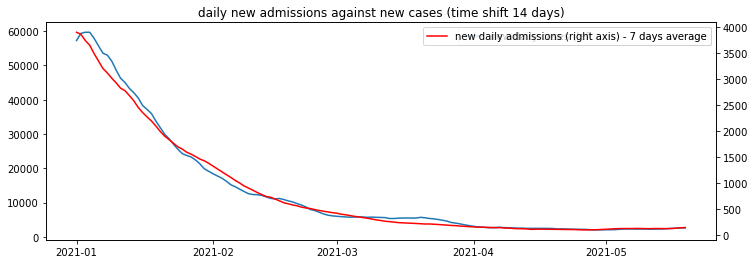

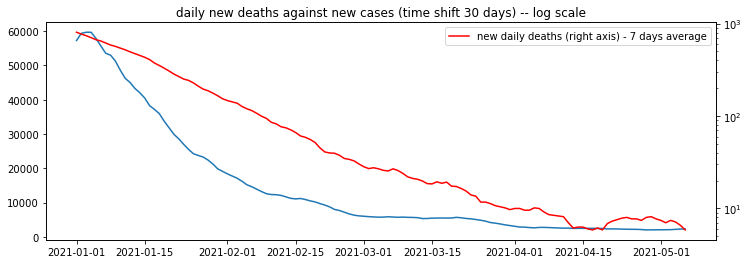

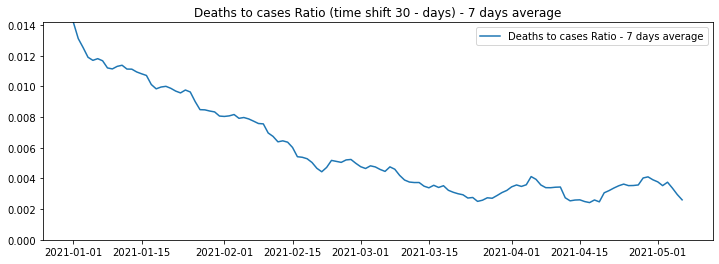

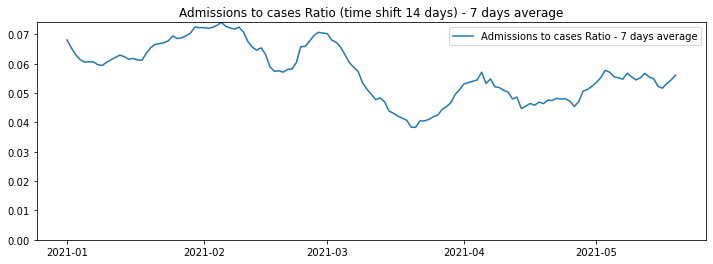

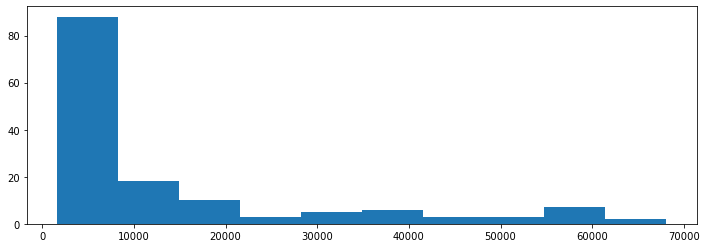

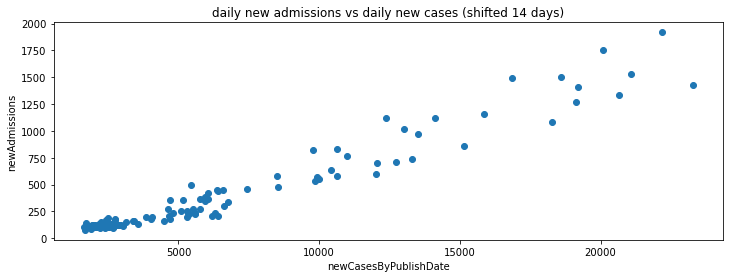

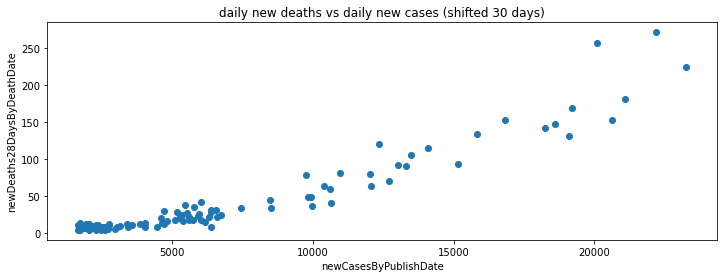

In [145]:
threshold = 25000
reportTimeSlice(filterByYearAndMonth(df, 2021), threshold)

## zooming in: 1/3/2021 --> today



** time interval: 2021-03-01 00:00:00 ---> 2021-06-13 00:00:00
** new daily cases vs admissions and deaths within the time slice ** 


total days in the range: 105
total days used for admissions: 86
total days used for deaths: 73
Pearson's correlation - daily cases vs daily admissions:0.85
Pearson's correlation - daily cases vs daily deaths:0.80


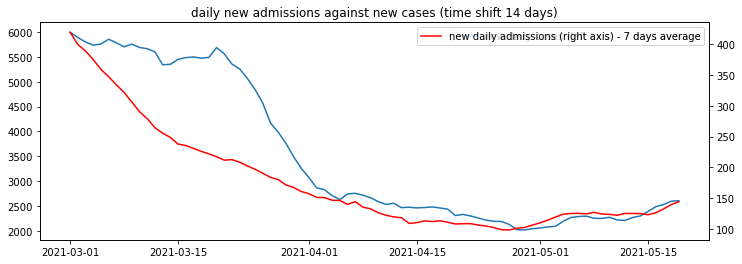

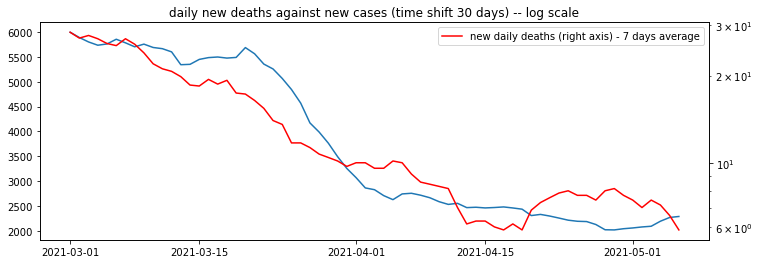

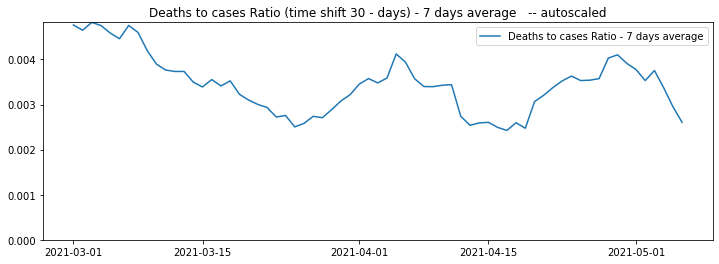

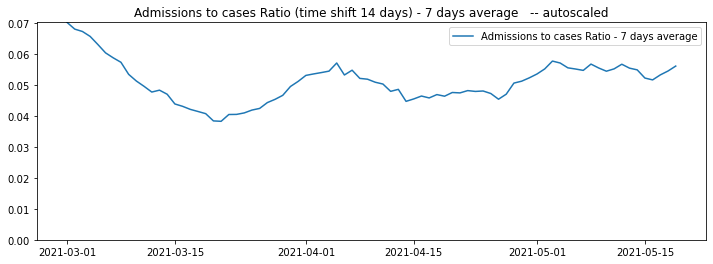

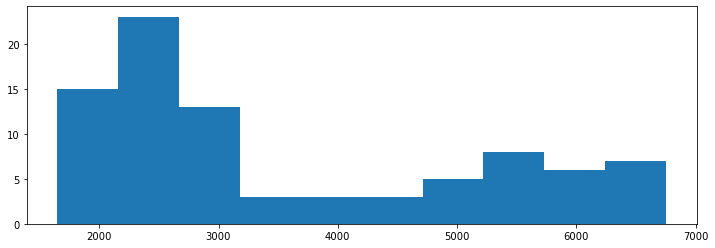

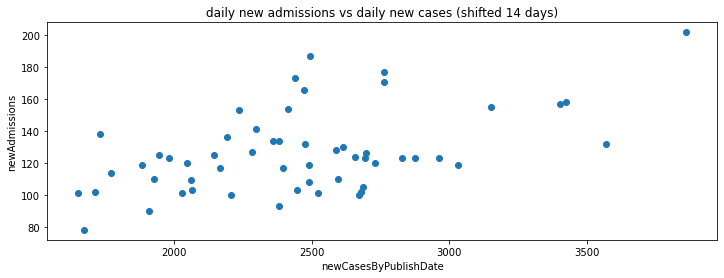

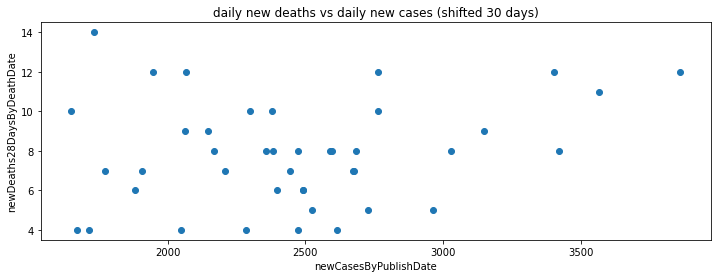

In [147]:
threshold = 4000
reportTimeSlice(filterByYearAndMonth(df, 2021, 3,6), threshold)

## zooming out: entire 2020



** time interval: 2020-01-31 00:00:00 ---> 2020-12-31 00:00:00
** new daily cases vs admissions and deaths within the time slice ** 


total days in the range: 336
total days used for admissions: 284
total days used for deaths: 254
Pearson's correlation - daily cases vs daily admissions:0.54
Pearson's correlation - daily cases vs daily deaths:0.72


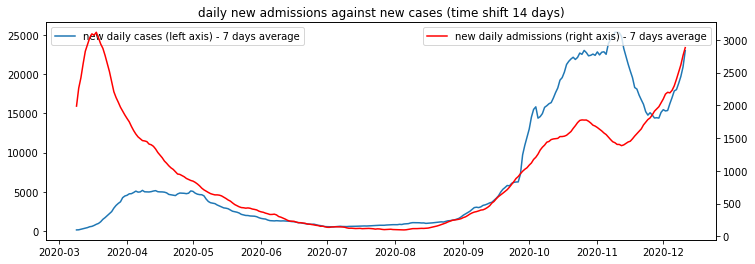

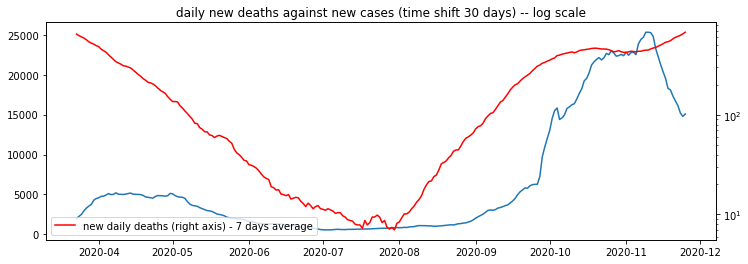

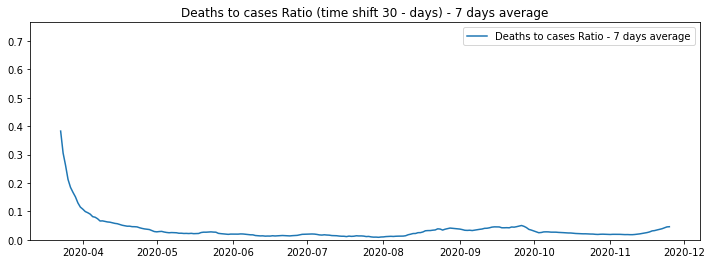

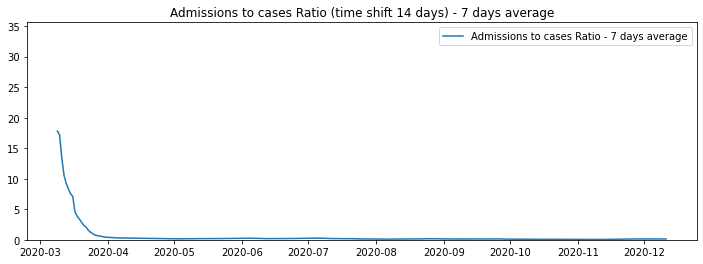

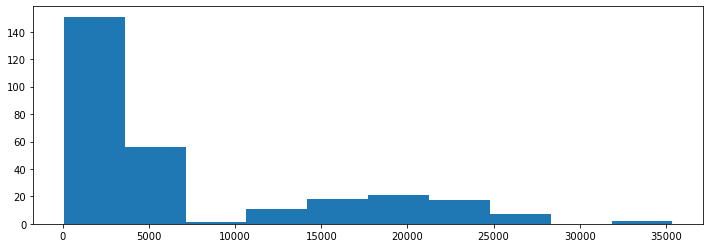

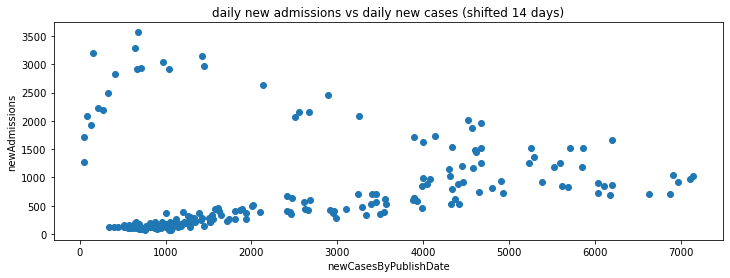

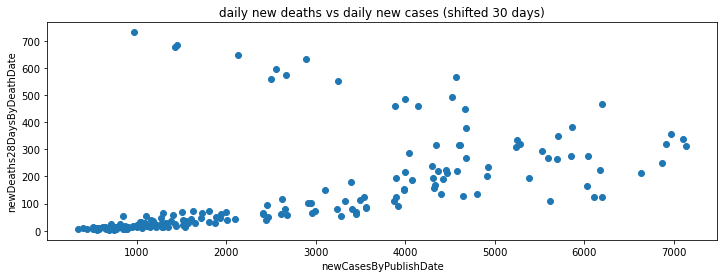

In [141]:
threshold = 10000
reportTimeSlice(filterByYearAndMonth(df, 2020), threshold)

## zooming way out: entire timeline



** time interval: 2020-01-31 00:00:00 ---> 2021-06-13 00:00:00
** new daily cases vs admissions and deaths within the time slice ** 


total days in the range: 500
total days used for admissions: 443
total days used for deaths: 416
Pearson's correlation - daily cases vs daily admissions:0.77
Pearson's correlation - daily cases vs daily deaths:0.70


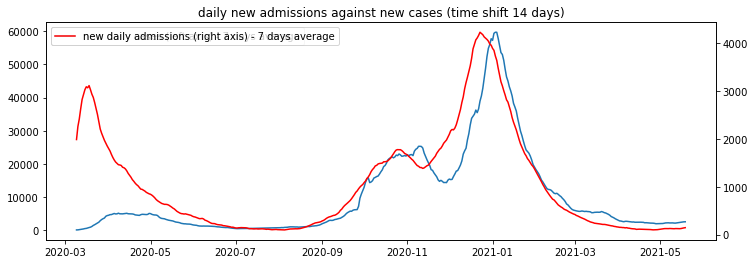

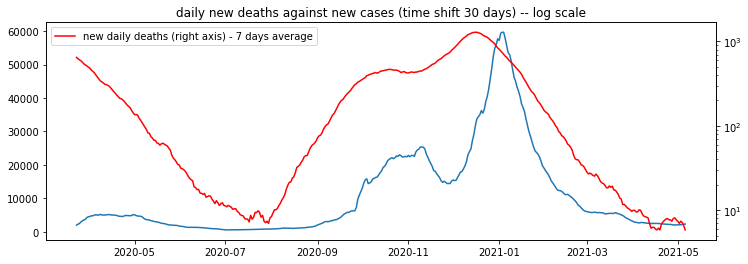

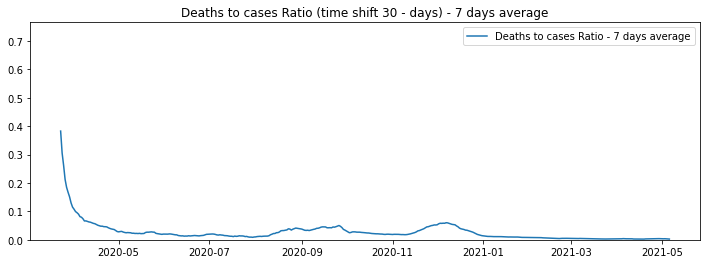

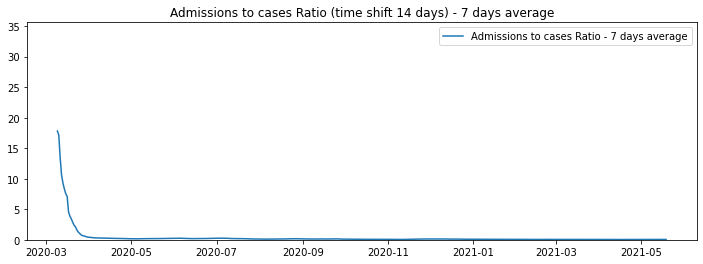

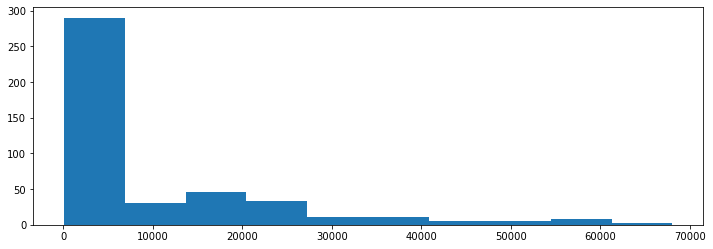

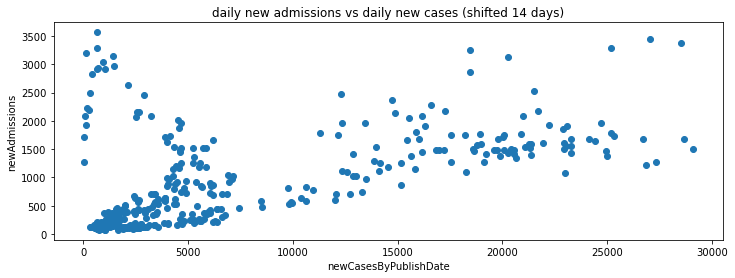

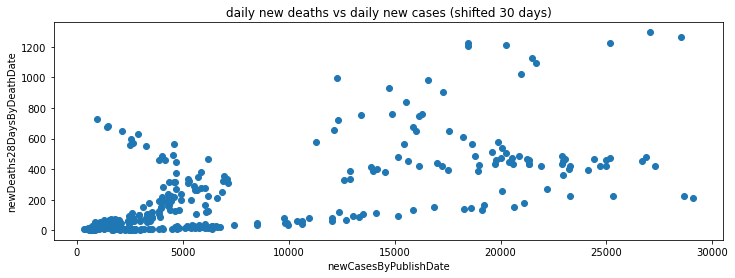

In [143]:
threshold = 30000
reportTimeSlice(filterByYearAndMonth(df), threshold)

density plot -- distribution of cases


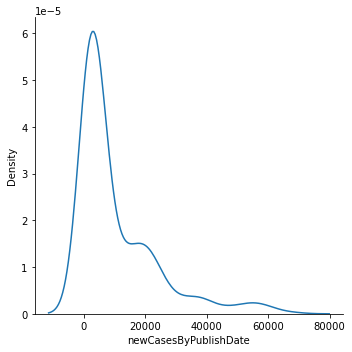

In [6]:
## distribution of new cases -- used to decide on a threshold for correlation analysis

print("density plot -- distribution of cases")
sns.displot(data=df1, x=CASES, kind='kde', log_scale=False)

### based on density plot, zoom in 0-10000 cases

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.60
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.22


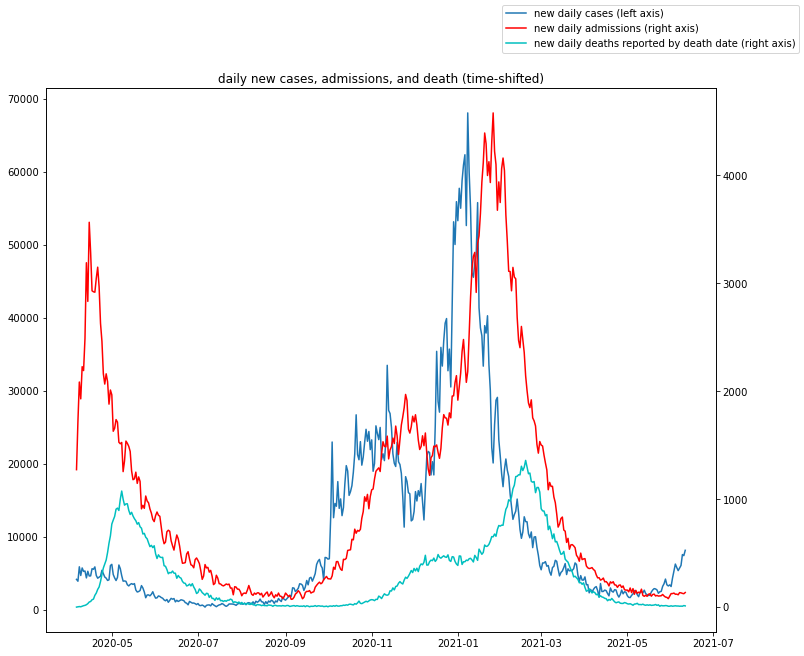

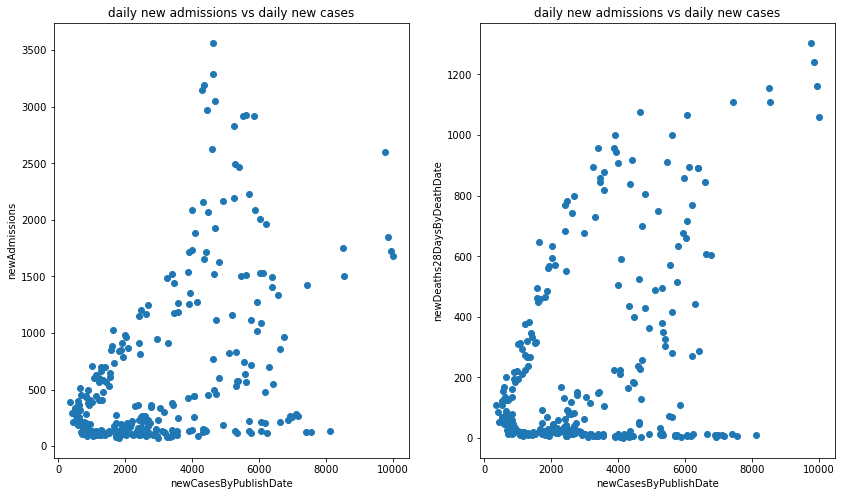

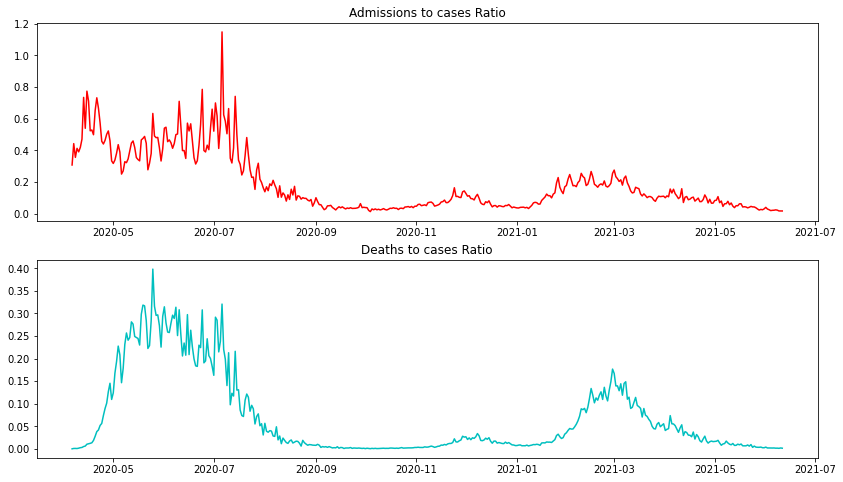

In [7]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [8]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate
count      432.000000
mean     10533.395833
std      13260.549576
min        343.000000
25%       1944.500000
50%       4594.000000
75%      15908.750000
max      68053.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions
count     432.000000
mean     1071.655093
std      1072.258024
min        72.000000
25%       196.000000
50%       640.000000
75%      1617.000000
max      4578.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate
count     432.000000
mean      295.576389
std       336.682517
min         0.000000
25%        23.750000
50%       138.500000
75%       464.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



## time: all of 2020

In [9]:
df1 = filterByYearAndMonth(df, 2020)
df1 = removeNullRecords(shiftColumnBy(ADM, 14, shiftColumnBy(DEATHS, 30, df1)))

df1.head()

,areaCode,areaName,areaType,date,newAdmissions,newCasesByPublishDate,newDeaths28DaysByDeathDate
162,K02000001,United Kingdom,overview,2020-12-31,2144.0,55892,399.0
163,K02000001,United Kingdom,overview,2020-12-30,2079.0,50023,423.0
164,K02000001,United Kingdom,overview,2020-12-29,1957.0,53135,464.0
165,K02000001,United Kingdom,overview,2020-12-28,1955.0,41385,467.0
166,K02000001,United Kingdom,overview,2020-12-27,1753.0,30501,423.0


density plot -- distribution of cases


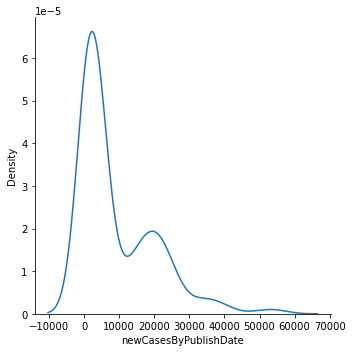

In [10]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x=CASES, kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.41
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.07


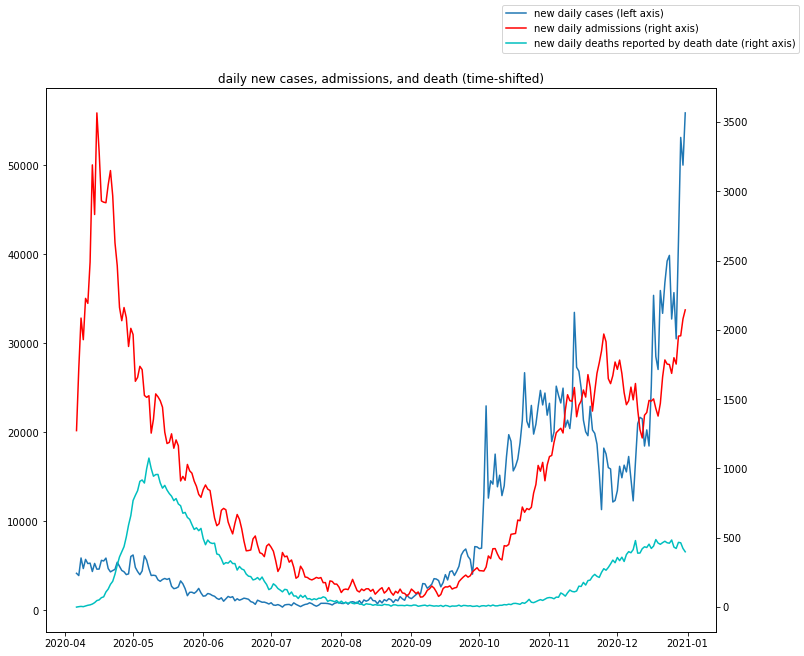

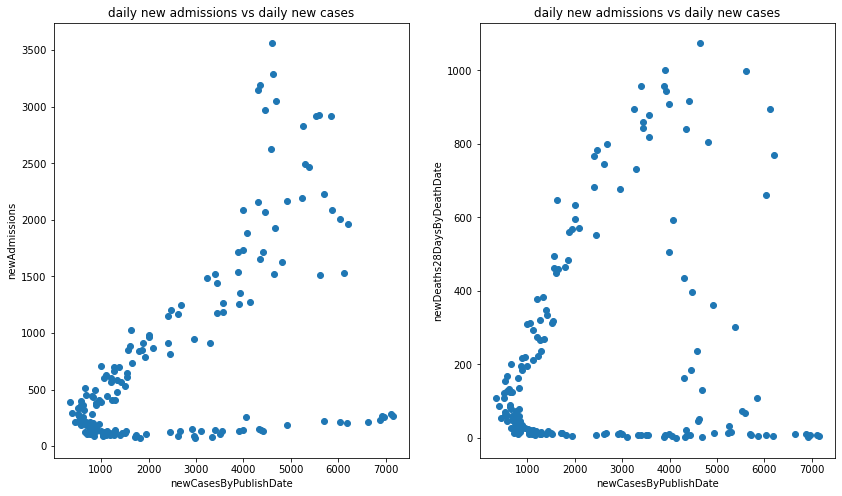

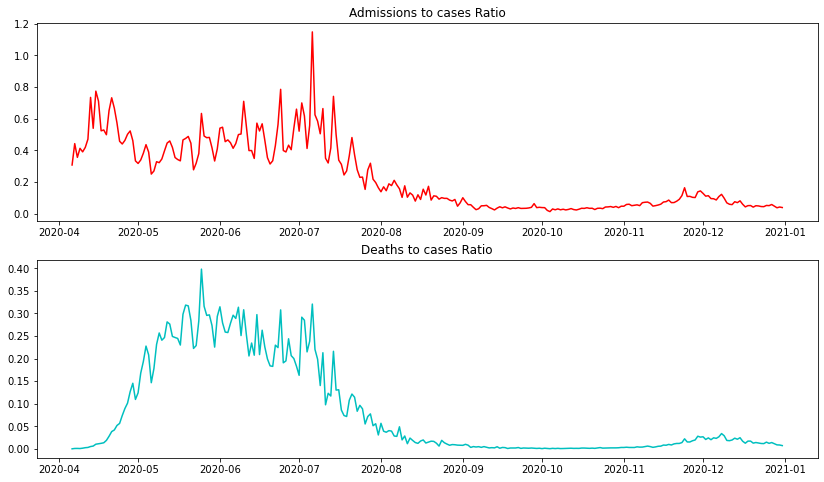

In [11]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [12]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate
count      270.000000
mean      9152.048148
std      10838.441716
min        343.000000
25%       1189.250000
50%       3993.500000
75%      16266.250000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions
count     270.000000
mean      921.677778
std       785.238029
min        72.000000
25%       213.250000
50%       700.000000
75%      1500.250000
max      3565.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate
count     270.000000
mean      225.125926
std       262.331877
min         0.000000
25%        18.500000
50%       102.500000
75%       387.500000
max      1075.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### plot second half of 2020

In [13]:
df1 = filterByYearAndMonth(df, 2020, 8,12)
df1 = removeNullRecords(shiftColumnBy(ADM, 14, shiftColumnBy(DEATHS, 30, df1)))

density plot -- distribution of cases


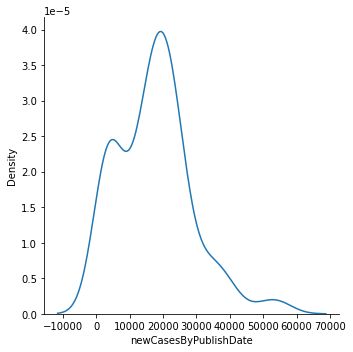

In [14]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x=CASES, kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.75
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.62


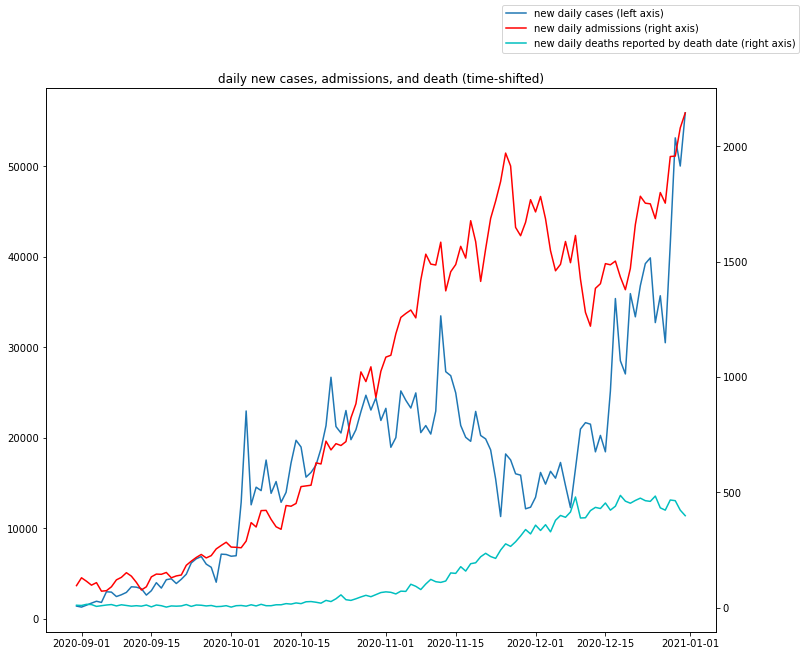

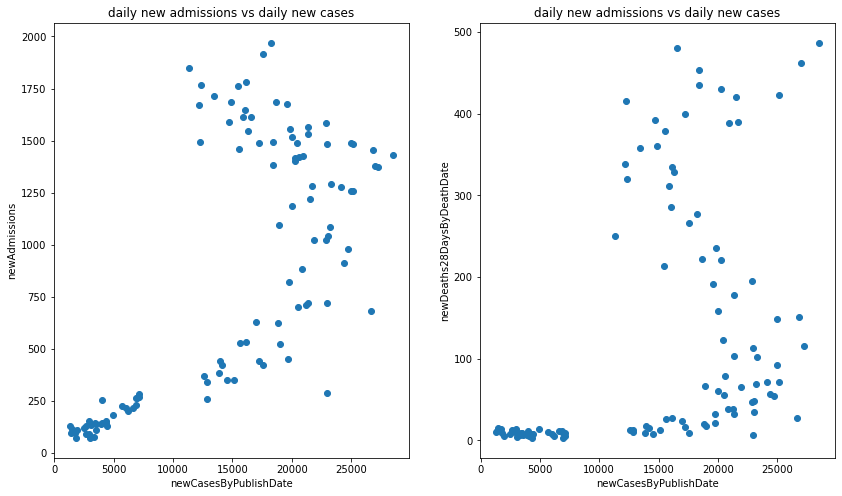

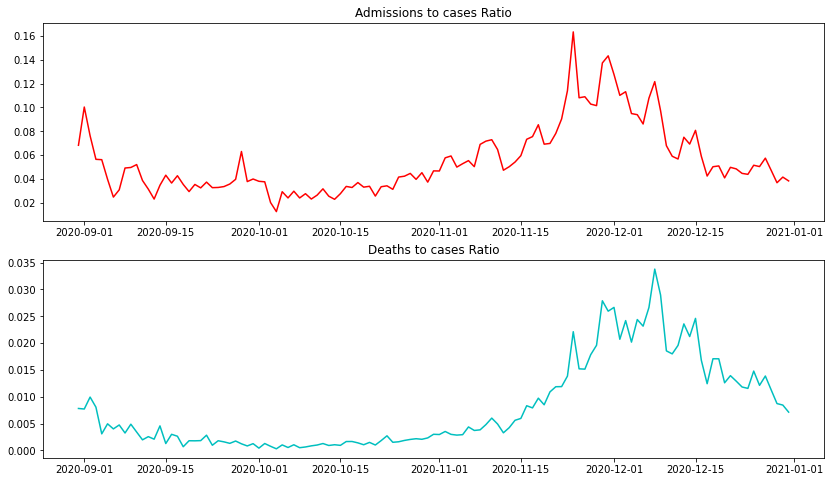

In [15]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=30000)

plotRatios(df1)

In [16]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate
count      123.000000
mean     17525.528455
std      11211.001732
min       1295.000000
25%       7038.000000
50%      17555.000000
75%      22955.500000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions
count     123.000000
mean      962.715447
std       654.837090
min        72.000000
25%       262.500000
50%      1044.000000
75%      1539.500000
max      2144.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate
count    123.000000
mean     157.991870
std      174.771068
min        3.000000
25%       12.000000
50%       60.000000
75%      332.000000
max      487.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### plot all of 2021

In [17]:
df1 = filterByYearAndMonth(df, 2021)
df1 = removeNullRecords(shiftColumnBy(ADM, 14, shiftColumnBy(DEATHS, 30, df1)))

density plot -- distribution of cases


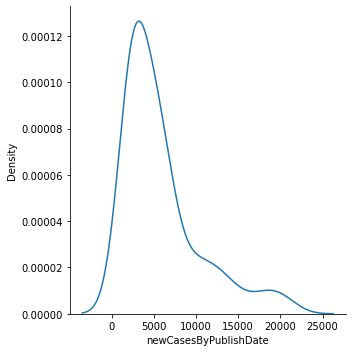

In [18]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x=CASES, kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.94
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.77


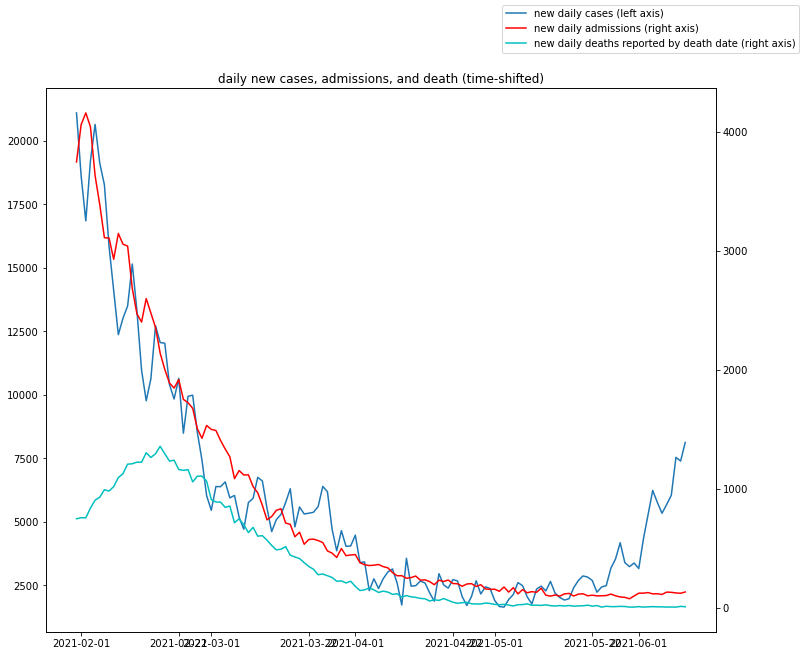

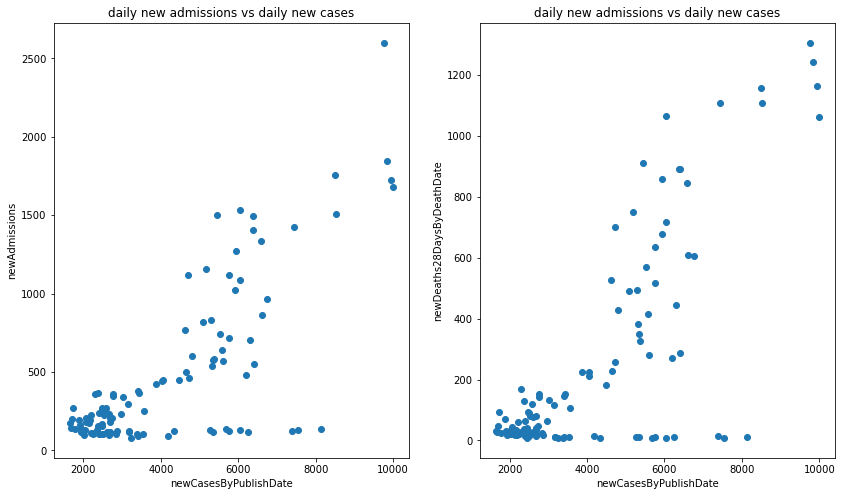

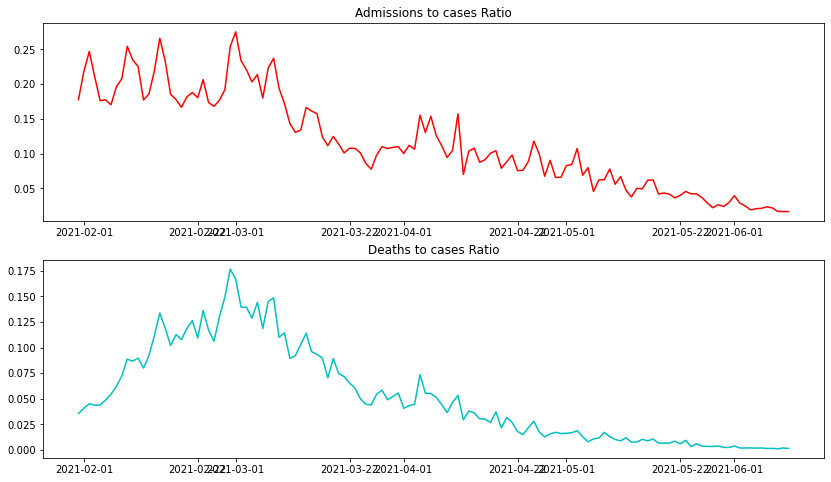

In [19]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [20]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate
count      132.000000
mean      5848.939394
std       4561.599975
min       1649.000000
25%       2516.250000
50%       4548.500000
75%       6582.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions
count     132.000000
mean      867.681818
std      1055.330738
min        78.000000
25%       134.000000
50%       352.500000
75%      1287.250000
max      4160.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate
count     132.000000
mean      388.583333
std       445.835112
min         8.000000
25%        24.000000
50%       138.000000
75%       752.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### zoom in 1-4 2021

In [21]:
df1 = filterByYearAndMonth(df, 2021, 1,4)
df1 = removeNullRecords(shiftColumnBy(ADM, 14, shiftColumnBy(DEATHS, 30, df1)))

density plot -- distribution of cases


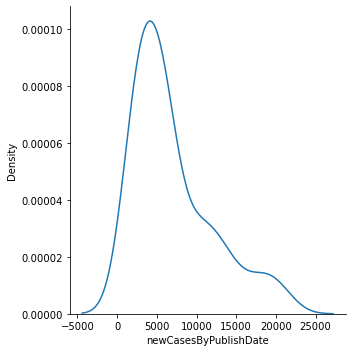

In [22]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x=CASES, kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.97
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.75


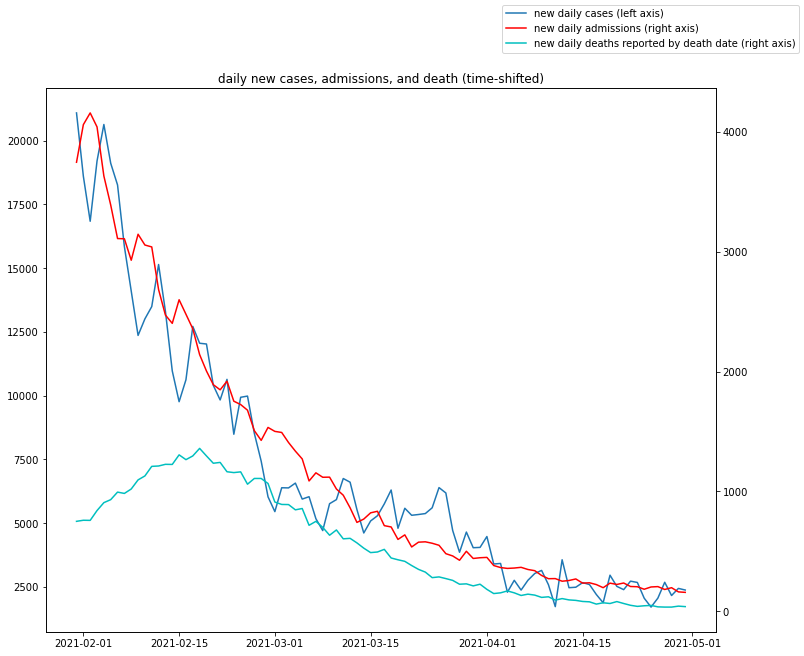

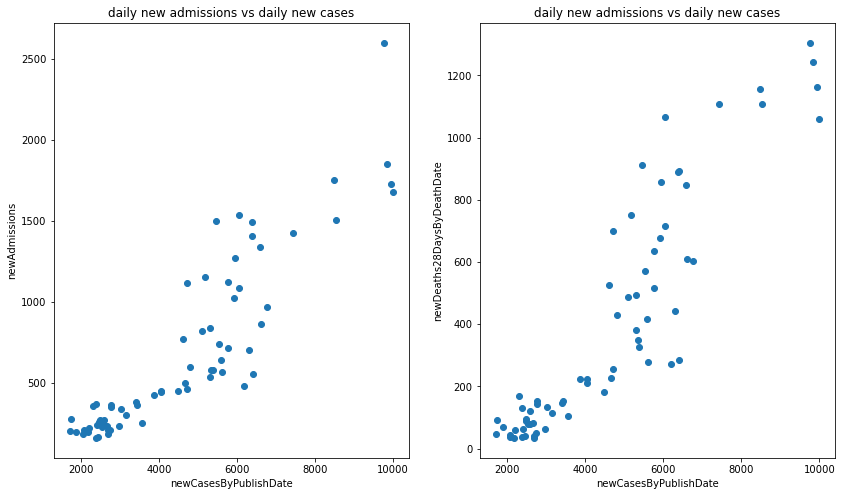

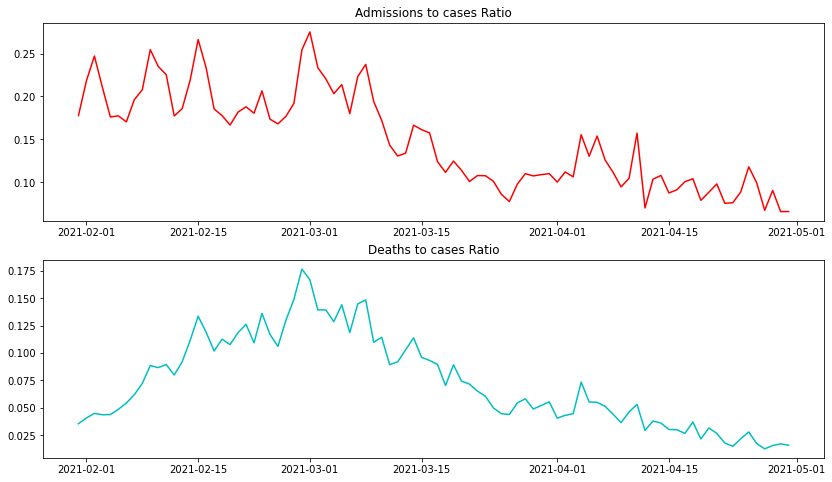

In [23]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [24]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate
count       90.000000
mean      6993.633333
std       5005.827172
min       1712.000000
25%       2813.000000
50%       5494.500000
75%       9912.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions
count      90.000000
mean     1215.877778
std      1119.714649
min       157.000000
25%       340.500000
50%       727.500000
75%      1824.250000
max      4160.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate
count      90.000000
mean      561.788889
std       444.069776
min        34.000000
25%       131.750000
50%       491.500000
75%       970.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 

